# CPO Notebook

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import time
import missingno
import optuna
import pandas_ta as ta

c:\Users\alber\python_projects\IP_AI_project\IP_AI_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters and data loading

,EQ CHINA,SX5E,SPX,EQ LAT,EQ PEXJP,EQ CHINA_rsi,EQ CHINA_roc,EQ CHINA_mom,EQ CHINA_ema50,EQ CHINA_ema200,...,S&P 500 INDUSTRIA,S&P 500 CONS STAPL,S&P 500 COMM,S&P 500 REAL ESTA,RF_US,RF_EU,US_EPS,SXXE,EU_EPS,Govies Euro Volatility
date,,,,,,,,,,,,,,,,,,,,,
2005-04-26,0.009982,-0.001282,-0.008915,0.009045,0.000919,54.144855,-363.036045,0.013777,0.000284,0.000659,...,-0.012080,-0.006843,-0.006514,-0.002906,0.004238,-0.000290,-0.000013,-0.002048,0.000000,-0.000289
2005-04-27,-0.005465,-0.013609,0.004029,-0.010156,-0.001801,47.306049,-175.828771,-0.012671,0.000059,0.000598,...,0.003176,0.004664,0.018116,0.008488,-0.009777,-0.010438,0.000000,-0.014546,0.000000,0.002387
2005-04-28,0.002415,-0.003993,-0.011380,-0.026060,0.001447,50.826219,-126.932436,0.011381,0.000151,0.000616,...,-0.013099,-0.004898,-0.005253,-0.011137,-0.018706,-0.004395,0.000000,-0.004499,0.000000,0.000894
2005-05-12,-0.001012,0.007605,-0.010033,-0.014054,-0.002471,49.080036,-141.891712,-0.003426,0.000331,0.000633,...,-0.011994,-0.005234,-0.004227,-0.012215,-0.007544,0.002408,-0.000877,0.006360,0.002015,-0.000474
2005-05-13,-0.011307,0.000478,-0.004580,-0.008143,-0.009447,43.626198,145.338407,-0.006698,-0.000125,0.000514,...,-0.005578,-0.007745,-0.006151,-0.014674,-0.012709,-0.006907,0.002085,0.000511,0.000000,0.001919
2005-05-18,0.000910,0.017581,0.010019,0.022368,0.006513,51.549454,-67.511278,-0.001891,-0.000925,0.000286,...,0.014721,0.009742,0.009433,0.008039,-0.006078,0.008174,0.000003,0.015642,0.000000,0.001546
2005-05-20,0.005558,-0.000439,-0.001511,-0.006063,-0.002757,52.809620,-837.749710,0.006312,-0.000152,0.000462,...,0.000035,-0.000453,-0.001941,0.006910,0.002311,0.007156,0.000000,0.000898,0.000000,-0.002003
2005-05-23,-0.007709,0.006730,0.003851,0.002375,0.010450,46.809884,-242.091985,-0.013134,-0.000449,0.000380,...,0.006476,0.001361,0.001522,-0.003990,-0.016307,-0.011545,0.000007,0.005022,0.000000,0.002912
2005-05-24,0.002910,-0.001443,0.000176,0.005116,0.007120,51.690925,-228.231690,0.005179,-0.000317,0.000406,...,-0.002145,-0.002430,-0.002532,-0.011376,-0.006586,-0.011081,-0.000270,-0.002391,-0.000197,0.002067


<Axes: >

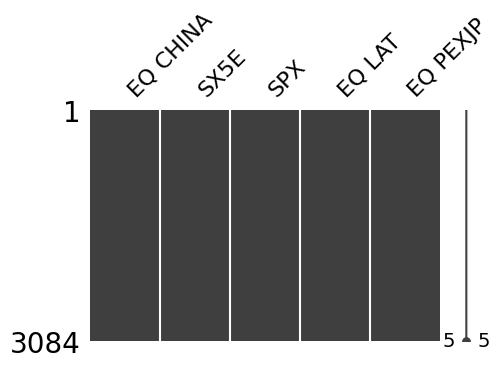

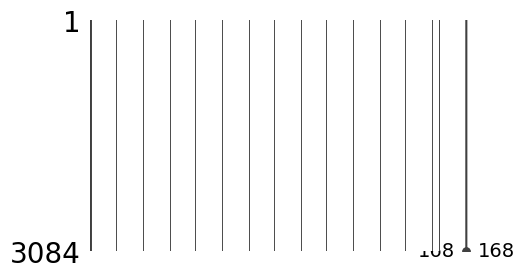

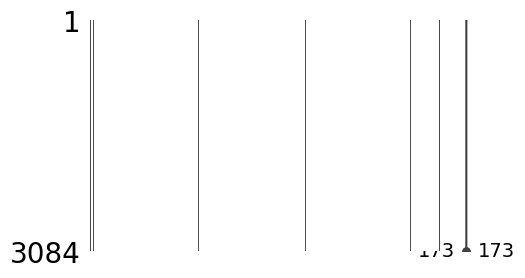

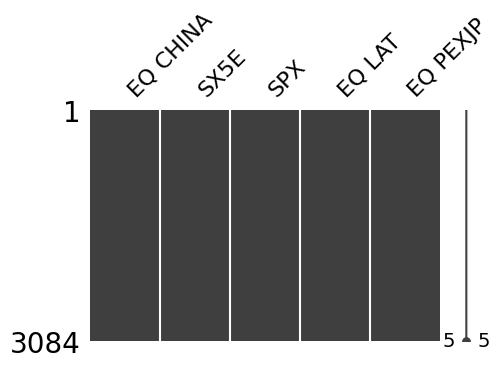

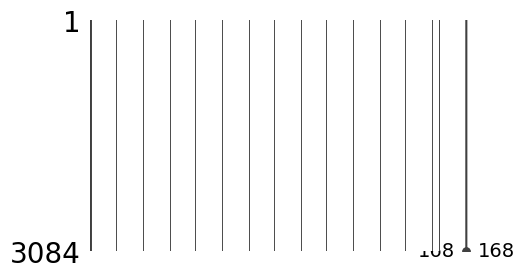

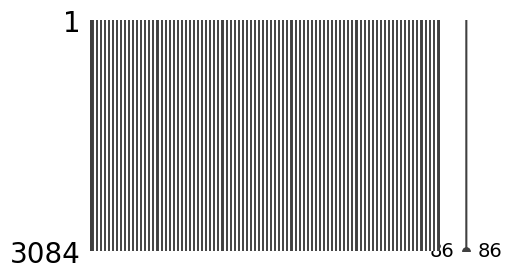

In [2]:
n_assets = 5
N = 50      # combinations
rnd_seed = 42
date_start = '2004-01-30' # First available: 2004-07-21
date_start = pd.to_datetime(date_start)

# Select metric for evaluation 1\2\3 (r2\mean_absolute_error\directional_accuracy)
metric_choice = '2' # Must be in ' '


# Data loading and cleaning
asset_returns = pd.read_csv('asset_returns.csv')
features = pd.read_csv('features.csv')

asset_returns['date'] = pd.to_datetime(asset_returns['date'])
features['date'] = pd.to_datetime(features['date'])

asset_returns = asset_returns.set_index("date")
features = features.set_index("date")

df = asset_returns.merge(features, left_index=True, right_index=True, how="inner")
df = df.dropna()
display(df.head(20))


asset_returns = df.iloc[:, :5] # taking first 5 columns as assets returns
features = df.iloc[:, 5:] # taking the rest of the columns as features

# Checking data frames with missingno
missingno.matrix(asset_returns, figsize=(5, 3))
missingno.matrix(features, figsize=(5, 3))
missingno.matrix(df, figsize=(5, 3))
missingno.matrix(asset_returns, figsize=(5, 3))
missingno.matrix(features, figsize=(5, 3))

# Removing correlated features
correlations = features.corr().mean()
features_name = (correlations[(correlations < 0.05) & (correlations > -0.05)].index).to_list()
features = features[features_name]
missingno.matrix(features, figsize=(5, 3))


### Functions

In [3]:
def plot_feature_importance(model, feature_names, model_name):
    
    #Plots and prints the top 10 most important features.
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)


    # Plot the feature importance
    plt.figure(figsize=(8, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()

In [4]:
# Rolling Sharpe Ratio calculation
def rolling_sharpe_ratio(returns, window=30, risk_free_rate=0.00007858): # Daily risk-free considering 0.02% annual rate

    excess_returns = returns - risk_free_rate
    rolling_mean = pd.Series(excess_returns).rolling(window).mean()
    rolling_std = pd.Series(excess_returns).rolling(window).std()
    sharpe_ratio = rolling_mean / rolling_std

    # Replace infinities with 0
    sharpe_ratio.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Ensure no NaN values
    sharpe_ratio.fillna(0, inplace=True)

    return sharpe_ratio

In [5]:
# Cross validation function

def time_grouped_cv(model, X, y):
    
    kf = KFold(n_splits=5, shuffle=False)
    scores = []
    
    combined_matrix_filtered = combined_matrix.loc[X.index].copy()
    combined_matrix_filtered['time_step'] = combined_matrix_filtered['time_step'].reset_index(drop=True)
    
    print("\nStarting Time-Grouped Cross-Validation...")
    for fold, (train_idx, test_idx) in enumerate(kf.split(np.unique(combined_matrix_filtered['time_step'])), start=1):

        train_steps = combined_matrix_filtered['time_step'].iloc[train_idx].values
        test_steps = combined_matrix_filtered['time_step'].iloc[test_idx].values
        
        train_mask = combined_matrix_filtered['time_step'].isin(train_steps).values
        test_mask = combined_matrix_filtered['time_step'].isin(test_steps).values       
        
        X_train, X_test = X.loc[train_mask], X.loc[test_mask]
        y_train, y_test = y.loc[train_mask], y.loc[test_mask]        
                
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        # Calculate selected metric
        score = selected_metric_func(y_test, y_pred)
        scores.append(score)

        
    mean_score = np.mean(scores)

    return mean_score


In [6]:
# Based on the chosen metric the function evaluates the model
def evaluate_model(name, model, X_test, y_test, metric):
    y_pred = model.predict(X_test)
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    

    # Calculate Directional Accuracy
    y_pred_dir = np.sign(y_pred)
    y_test_dir = np.sign(y_test)
    directional_accuracy = np.mean(y_pred_dir == y_test_dir)
    
    # Display results based on selected metric
    print(f"\nEvaluating {name} Model...")
    print(f"{name} Model Results:")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Directional Accuracy: {directional_accuracy:.4f}")
    print("-" * 40)

    # Return selected metric score
    if metric == "R²":
        return r2
    elif metric == "MAE":
        return mae
    elif metric == "DA":
        return directional_accuracy
    else:
        raise ValueError(f"Invalid metric selected: {metric}")


In [7]:
def plot_feature_importances(model, feature_names, model_name):
    
    """Plots and prints the top 10 most important features."""
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)


    # Plot the feature importance
    plt.figure(figsize=(8, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()
    
def directional_accuracy(y_true, y_pred):
    """Calculates the percentage of times the predicted and actual returns have the same sign."""
    correct_directions = (np.sign(y_true) == np.sign(y_pred)).sum()
    return correct_directions / len(y_true)


In [8]:
def custom_random_search(model, param_grid, X, y, n_iter=10):
    best_score = -np.inf
    best_params = None
    feature_columns = X.columns.tolist()  # Get the feature names directly from X
        

    
    for i in range(n_iter):
        params = {k: np.random.choice(v) for k, v in param_grid.items()}
        model.set_params(**params)
        
        score = time_grouped_cv(model, X, y)

        
        if score > best_score:
            best_score = score
            best_params = params
    
    
    model.set_params(**best_params)    
    model.fit(X, y)
    # Feature Importance Extraction
    if hasattr(model, "feature_importances_"):
        plot_feature_importances(model, feature_columns, model.__class__.__name__)
    return model, best_score, best_params

In [9]:
def directional_accuracy(y_true, y_pred):
    """Calculates the percentage of times the predicted and actual returns have the same sign."""
    correct_directions = (np.sign(y_true) == np.sign(y_pred)).sum()
    return correct_directions / len(y_true)

### Hyperparameters

In [10]:
# Define hyperparameter grids

gbr_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10, 20, 30],    # Added regularization
    'min_samples_leaf': [1, 2, 4]               # Added regularization
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],              # Added regularization
    'gamma': [0, 0.1, 0.2],                     # Added regularization
    'reg_alpha': [0, 0.1, 0.5],                 # L1 regularization (lasso)
    'reg_lambda': [1, 1.5, 2.0, 3.0]            # L2 regularization (ridge)
}

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],           # Added regularization
    'max_samples': [0.5, 0.75, 1.0]             # Added regularization
}


### Error metric choice

In [11]:
# Map choice to metric
metric_map = {
    "1": ("R²", r2_score),
    "2": ("MAE", mean_absolute_error),
    "3": ("DA", directional_accuracy)
}
selected_metric_name, selected_metric_func = metric_map[metric_choice]
print(f"Selected metric: {selected_metric_name}")


Selected metric: MAE


### Random weights

In [12]:

# Generate random weight combinations using Dirichlet distribution
np.random.seed(rnd_seed)
random_weights = np.random.dirichlet(np.ones(n_assets), size=N)

# Convert to DataFrame
columns = []
for i in range(n_assets):
    columns.append('w'+str(i+1))

portfolio_weights = pd.DataFrame(random_weights, columns=columns)

display(portfolio_weights.head())

,w1,w2,w3,w4,w5
0,0.079825,0.512038,0.223986,0.155297,0.028854
1,0.038624,0.013628,0.458035,0.209311,0.280403
2,0.003617,0.609298,0.310675,0.041510,0.034900
3,0.091305,0.163472,0.335246,0.254855,0.155122
4,0.377441,0.059918,0.137802,0.181977,0.242862


### Combined matrix

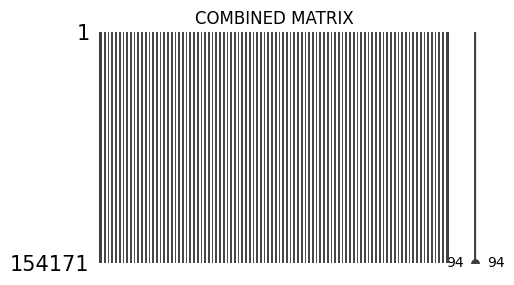

,w1,w2,w3,w4,w5,EQ CHINA_roc,EQ CHINA_ema200,EQ CHINA_mad,EQ CHINA_kurtosis,EQ CHINA_skew,...,CORP US,GOVIES SW,GOVIES JP,RF_EU,US_EPS,EU_EPS,Govies Euro Volatility,portfolio_return,sharpe_ratio,time_step
0,0.018280,0.457421,0.339735,0.025705,0.158859,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,-0.003054,0.559795,0
1,0.308815,0.035403,0.020235,0.086907,0.548640,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.004147,0.606887,0
2,0.062984,0.253429,0.325864,0.061663,0.296061,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,-0.001771,0.603348,0
3,0.137907,0.300914,0.301917,0.230801,0.028461,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.000413,0.664390,0
4,0.541262,0.116079,0.061949,0.012493,0.268217,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.005062,0.711601,0
5,0.358276,0.005295,0.227159,0.081295,0.327975,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.002581,0.698030,0
6,0.040227,0.246525,0.102656,0.579531,0.031061,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.004441,0.695801,0
7,0.075562,0.021818,0.468476,0.380103,0.054041,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.000038,0.646816,0
8,0.233522,0.367891,0.175371,0.163280,0.059936,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.001828,0.618963,0
9,0.016030,0.373195,0.378387,0.164471,0.067917,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,-0.002142,0.531001,0


In [13]:
# Number of time steps (T) and portfolios (N)
T = len(features)
N = len(portfolio_weights)


### Weights-Features matrix ###
# Create the correct NxT matrix
features_repeated = features.loc[features.index.repeat(N)].reset_index(drop=True) # Repeat each row of features N times
portfolio_repeated = pd.DataFrame(   # Tile (cycle) portfolio weights T times so they align with features
    np.tile(portfolio_weights, (T, 1)),
    columns=columns)
combined_matrix = pd.concat([portfolio_repeated, features_repeated], axis=1) # Combine features and weights side by side


### Adding PTF returns ###
# Recalculate portfolio returns using weights and asset returns
portfolio_returns = np.sum(portfolio_repeated.values * asset_returns.loc[asset_returns.index.repeat(N)].values, axis=1)
portfolio_returns_df = pd.DataFrame(portfolio_returns, columns=['portfolio_return'])  # Convert to DataFrame for consistency
combined_matrix['portfolio_return'] = portfolio_returns_df['portfolio_return'].values # Add portfolio returns to the combined matrix
combined_matrix['portfolio_return'] = portfolio_returns_df['portfolio_return'].values # Add portfolio returns to the combined matrix


### Adding Sharpe Ratios ###
combined_matrix['sharpe_ratio'] = rolling_sharpe_ratio(combined_matrix['portfolio_return'], window=30) # Calculate Sharpe ratios for all rows (NxT)
combined_matrix['sharpe_ratio'].fillna(0, inplace=True) # Handle NaNs by replacing with zero 
combined_matrix = combined_matrix[combined_matrix['sharpe_ratio'] != 0].reset_index(drop=True) # Remove rows where Sharpe ratio is NaN or zero


# Group rows by time steps
time_steps = np.arange(len(features))
combined_matrix['time_step'] = np.repeat(time_steps, N)[:len(combined_matrix)] # Assign time step groups, repeated N times (so rows for t1-tN are grouped)


### Checks ###
missingno.matrix(combined_matrix,figsize=(5,3), fontsize=12)
plt.title("COMBINED MATRIX")
plt.show()

# Now the combined matrix has the following structure: weights (5), features (86), portfolio returns (1), sharpe ratio (1), time steps (1)
display(combined_matrix.head(10))

# Substitute infinities 
combined_matrix = combined_matrix.replace([float("inf"), float("-inf")]).dropna()



### Prediction Matrix

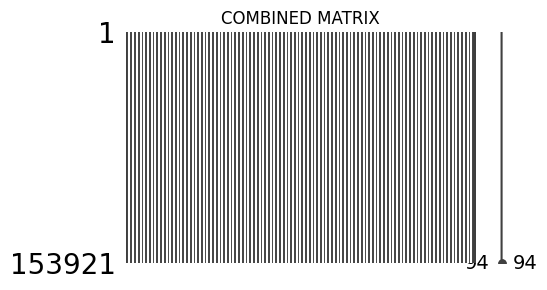

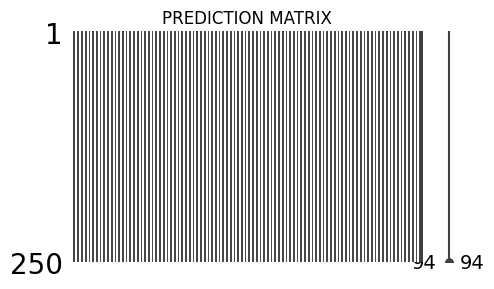

X shape: (153921, 91), y shape: (153921,)
Matching indices: True


In [14]:
# PREDICTION MATRIX
N_P = 5 # how many time step to predict from bottom
predict_matrix = combined_matrix[(-N*N_P):]
combined_matrix = combined_matrix[0:(-N*N_P)]


### Checks ###
missingno.matrix(combined_matrix, figsize=(5,3))
plt.title("COMBINED MATRIX")
plt.show()

missingno.matrix(predict_matrix, figsize=(5,3))
plt.title("PREDICTION MATRIX")
plt.show()


# Prepare features (X) and target (y)
X = combined_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])
y = combined_matrix['sharpe_ratio']

# Ensure indices of X and y match
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Matching indices: {(X.index == y.index).all()}")

# Split data into training and testing sets
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]



### Model Training


Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...


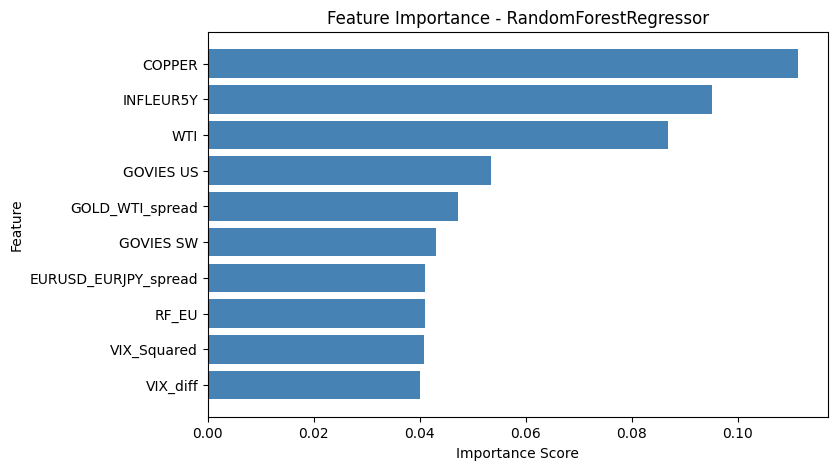


Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...


In [ ]:
gbr = GradientBoostingRegressor(random_state=rnd_seed)
rf = RandomForestRegressor(random_state=rnd_seed)
xgb = XGBRegressor(random_state=rnd_seed)


# Random search with time grouping
rf_best_model, rf_best_score, rf_best_params = custom_random_search(rf, rf_params, X_train, y_train)
gbr_best_model, gbr_best_score, gbr_best_params = custom_random_search(gbr, gbr_params, X_train, y_train)
xgb_best_model, xgb_best_score, xgb_best_params = custom_random_search(xgb, xgb_params, X_train, y_train)


print("\nBest Random Forest hyperparameters:", rf_best_params)
print("Regularization params (RF): max_features={}, max_samples={}".format(
    rf_best_params.get('max_features'), rf_best_params.get('max_samples')))

print("\nBest Gradient Boosting hyperparameters:", gbr_best_params)
print("Regularization params (GBR): min_samples_split={}, min_samples_leaf={}".format(
    gbr_best_params.get('min_samples_split'), gbr_best_params.get('min_samples_leaf')))

print("\nBest XGBoost hyperparameters:", xgb_best_params)
print("Regularization params (XGB): min_child_weight={}, gamma={}, reg_alpha={}, reg_lambda={}".format(
    xgb_best_params.get('min_child_weight'), 
    xgb_best_params.get('gamma'),
    xgb_best_params.get('reg_alpha'),
    xgb_best_params.get('reg_lambda')))

_ = evaluate_model("Random Forest", rf_best_model, X_test, y_test,"MAE")
_ = evaluate_model("Gradient Boosting", gbr_best_model, X_test, y_test,"MAE")
_ = evaluate_model("XGBoost", xgb_best_model, X_test, y_test,"MAE")


# prediction
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
X_pred = predict_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])

yhat_rf = rf_best_model.predict(X_pred)
yhat_gbr = gbr_best_model.predict(X_pred)
yhat_xgb = xgb_best_model.predict(X_pred)

X_pred['yhat_rf'] = yhat_rf
X_pred['yhat_gbr'] = yhat_gbr
X_pred['yhat_xgb'] = yhat_xgb

valid_assets = [col for col in asset_returns if col in X_pred.columns]
W_rf = X_pred[X_pred['yhat_rf'] == X_pred['yhat_rf'].max()][valid_assets]
W_gbr = X_pred[X_pred['yhat_gbr'] == X_pred['yhat_gbr'].max()][valid_assets]
W_xgb = X_pred[X_pred['yhat_xgb'] == X_pred['yhat_xgb'].max()][valid_assets]

print(W_xgb)






In [ ]:
def objective(trial, X, y, model_type="rf"):
    if model_type == "rf":
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
            max_features=trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            max_samples=trial.suggest_float("max_samples", 0.5, 1.0),
            random_state=42
        )
        
    elif model_type == "xgb":
        from xgboost import XGBRegressor
        model = XGBRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.7, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.7, 1.0),
            gamma=trial.suggest_float("gamma", 0, 0.3),
            reg_alpha=trial.suggest_float("reg_alpha", 0, 1.0),
            reg_lambda=trial.suggest_float("reg_lambda", 1, 3.0),
            random_state=42
        )

    elif model_type == "gbr":
        from sklearn.ensemble import GradientBoostingRegressor
        model = GradientBoostingRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.7, 1.0),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
            random_state=42
        )

    else:
        raise ValueError("Unknown model type")

    score = time_grouped_cv(model, X, y)
    return score






study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(lambda trial: objective(trial, X_train, y_train, model_type="rf"), n_trials=10)

print("Best RF hyperparameters:", study_rf.best_params)
rf_best_model = RandomForestRegressor(**study_rf.best_params, random_state=42)
rf_best_model.fit(X_train, y_train)

study_gbr = optuna.create_study(direction="maximize")
study_gbr.optimize(lambda trial: objective(trial, X_train, y_train, model_type="gbr"), n_trials=10)

print("Best GBR hyperparameters:", study_gbr.best_params)
gbr_best_model = GradientBoostingRegressor(**study_gbr.best_params, random_state=42)
gbr_best_model.fit(X_train, y_train)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(lambda trial: objective(trial, X_train, y_train, model_type="xgb"), n_trials=10)

print("Best XGB hyperparameters:", study_xgb.best_params)
xgb_best_model = XGBRegressor(**study_xgb.best_params, random_state=42)
xgb_best_model.fit(X_train, y_train)


# Create the best model and fit it
print("Best RF hyperparameters:", study_rf.best_params)
rf_best_model = RandomForestRegressor(**study_rf.best_params, random_state=42)
rf_best_model.fit(X_train, y_train)


_ = evaluate_model("Random Forest", rf_best_model, X_test, y_test,selected_metric_name)
_ = evaluate_model("Gradient Boosting", gbr_best_model, X_test, y_test,selected_metric_name)
_ = evaluate_model("XGBoost", xgb_best_model, X_test, y_test,selected_metric_name)


# prediction
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
X_pred = predict_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])

yhat_rf = rf_best_model.predict(X_pred)
yhat_gbr = gbr_best_model.predict(X_pred)
yhat_xgb = xgb_best_model.predict(X_pred)

X_pred['yhat_rf'] = yhat_rf
X_pred['yhat_gbr'] = yhat_gbr
X_pred['yhat_xgb'] = yhat_xgb

W_rf = X_pred[X_pred['yhat_rf'] == X_pred['yhat_rf'].max()][valid_assets]
W_gbr = X_pred[X_pred['yhat_gbr'] == X_pred['yhat_gbr'].max()][valid_assets]
W_xgb = X_pred[X_pred['yhat_xgb'] == X_pred['yhat_xgb'].max()][valid_assets]



[I 2025-03-27 09:39:21,526] A new study created in memory with name: no-name-51bae9a6-4eaa-4870-b3f0-07ac4a809f34



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:22,600] Trial 0 finished with value: 1.6307746498632212 and parameters: {'n_estimators': 131, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_samples': 0.9610190181928637}. Best is trial 0 with value: 1.6307746498632212.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:23,649] Trial 1 finished with value: 1.6483269403193526 and parameters: {'n_estimators': 251, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_samples': 0.5768218389989896}. Best is trial 1 with value: 1.6483269403193526.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:24,911] Trial 2 finished with value: 1.6220139428279303 and parameters: {'n_estimators': 234, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_samples': 0.5825673717687665}. Best is trial 1 with value: 1.6483269403193526.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:26,155] Trial 3 finished with value: 1.6384297879301677 and parameters: {'n_estimators': 213, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_samples': 0.8023769256152357}. Best is trial 1 with value: 1.6483269403193526.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:27,122] Trial 4 finished with value: 1.637213850637091 and parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_samples': 0.9824749009416137}. Best is trial 1 with value: 1.6483269403193526.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:28,089] Trial 5 finished with value: 1.6324741671293412 and parameters: {'n_estimators': 185, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_samples': 0.7311114448718186}. Best is trial 1 with value: 1.6483269403193526.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:29,072] Trial 6 finished with value: 1.593783166916584 and parameters: {'n_estimators': 113, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_samples': 0.8820079522298192}. Best is trial 1 with value: 1.6483269403193526.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:30,438] Trial 7 finished with value: 1.6072855921224103 and parameters: {'n_estimators': 194, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_samples': 0.8176980479173792}. Best is trial 1 with value: 1.6483269403193526.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:31,371] Trial 8 finished with value: 1.6158006535063572 and parameters: {'n_estimators': 120, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_samples': 0.6369341188998328}. Best is trial 1 with value: 1.6483269403193526.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:33,425] Trial 9 finished with value: 1.594296772845914 and parameters: {'n_estimators': 220, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_samples': 0.9928946842093174}. Best is trial 1 with value: 1.6483269403193526.


Best RF hyperparameters: {'n_estimators': 251, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_samples': 0.5768218389989896}


[I 2025-03-27 09:39:40,324] A new study created in memory with name: no-name-e50937f0-a3a4-4504-8fb0-e33d81c0d6bb



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:39:55,506] Trial 0 finished with value: 1.4628053985859069 and parameters: {'n_estimators': 248, 'max_depth': 7, 'learning_rate': 0.1508772950272438, 'subsample': 0.778536066545614, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 1.4628053985859069.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:40:16,704] Trial 1 finished with value: 1.5291987938234581 and parameters: {'n_estimators': 286, 'max_depth': 7, 'learning_rate': 0.24293576667477584, 'subsample': 0.9969121861852559, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 1.5291987938234581.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:40:24,473] Trial 2 finished with value: 1.6448357025342553 and parameters: {'n_estimators': 198, 'max_depth': 4, 'learning_rate': 0.041556157600173116, 'subsample': 0.9362945685136339, 'min_samples_split': 16, 'min_samples_leaf': 1}. Best is trial 2 with value: 1.6448357025342553.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:40:41,740] Trial 3 finished with value: 1.4626481608628545 and parameters: {'n_estimators': 232, 'max_depth': 9, 'learning_rate': 0.03054697356371698, 'subsample': 0.8673880039205945, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 2 with value: 1.6448357025342553.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:41:03,960] Trial 4 finished with value: 1.3814914417725443 and parameters: {'n_estimators': 290, 'max_depth': 8, 'learning_rate': 0.13928464392755874, 'subsample': 0.8816141177363261, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 1.6448357025342553.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:41:22,040] Trial 5 finished with value: 1.4605855072105451 and parameters: {'n_estimators': 248, 'max_depth': 9, 'learning_rate': 0.09606187848631285, 'subsample': 0.7778341013734891, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 1.6448357025342553.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:41:27,573] Trial 6 finished with value: 1.6019895137156859 and parameters: {'n_estimators': 148, 'max_depth': 4, 'learning_rate': 0.14573926325190156, 'subsample': 0.8481004516716367, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 1.6448357025342553.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:41:35,743] Trial 7 finished with value: 1.6208548426119975 and parameters: {'n_estimators': 242, 'max_depth': 4, 'learning_rate': 0.1106867869698388, 'subsample': 0.7471497222307646, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 2 with value: 1.6448357025342553.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:41:46,190] Trial 8 finished with value: 1.55957780563465 and parameters: {'n_estimators': 274, 'max_depth': 4, 'learning_rate': 0.12214349361477078, 'subsample': 0.8609007065820607, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 2 with value: 1.6448357025342553.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:41:52,577] Trial 9 finished with value: 1.51289880655257 and parameters: {'n_estimators': 124, 'max_depth': 6, 'learning_rate': 0.20083524137461473, 'subsample': 0.7834502280273502, 'min_samples_split': 17, 'min_samples_leaf': 2}. Best is trial 2 with value: 1.6448357025342553.


Best GBR hyperparameters: {'n_estimators': 198, 'max_depth': 4, 'learning_rate': 0.041556157600173116, 'subsample': 0.9362945685136339, 'min_samples_split': 16, 'min_samples_leaf': 1}


[I 2025-03-27 09:44:38,376] A new study created in memory with name: no-name-b6ea8611-60ef-45c6-8ab1-f97460ad70ec



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:44:39,219] Trial 0 finished with value: 1.6075850306179398 and parameters: {'n_estimators': 142, 'max_depth': 3, 'learning_rate': 0.11954413525613664, 'subsample': 0.9354991757711113, 'colsample_bytree': 0.784546519385803, 'gamma': 0.0004482144112940567, 'reg_alpha': 0.05293709928764356, 'reg_lambda': 2.611757667106705}. Best is trial 0 with value: 1.6075850306179398.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:44:40,217] Trial 1 finished with value: 1.6489040299848667 and parameters: {'n_estimators': 176, 'max_depth': 3, 'learning_rate': 0.053009224793968385, 'subsample': 0.9322257790643038, 'colsample_bytree': 0.8099768460504535, 'gamma': 0.053635736835659205, 'reg_alpha': 0.46029369835521494, 'reg_lambda': 1.102871826511902}. Best is trial 1 with value: 1.6489040299848667.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:44:41,962] Trial 2 finished with value: 1.4946812909841127 and parameters: {'n_estimators': 261, 'max_depth': 6, 'learning_rate': 0.2752806270855634, 'subsample': 0.8374362025637314, 'colsample_bytree': 0.7091301001923845, 'gamma': 0.05488506445626804, 'reg_alpha': 0.1300076780795819, 'reg_lambda': 1.7512222623743119}. Best is trial 1 with value: 1.6489040299848667.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:44:43,952] Trial 3 finished with value: 1.376748125643974 and parameters: {'n_estimators': 254, 'max_depth': 10, 'learning_rate': 0.12170067533484578, 'subsample': 0.704921924803573, 'colsample_bytree': 0.7027193305331804, 'gamma': 0.28181801242904825, 'reg_alpha': 0.808031690895915, 'reg_lambda': 2.085958509341314}. Best is trial 1 with value: 1.6489040299848667.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:44:45,200] Trial 4 finished with value: 1.5968839956457352 and parameters: {'n_estimators': 197, 'max_depth': 4, 'learning_rate': 0.02122617736510487, 'subsample': 0.7367392227487398, 'colsample_bytree': 0.8989620176282885, 'gamma': 0.1272940686039348, 'reg_alpha': 0.19990466118744665, 'reg_lambda': 2.6960529844755614}. Best is trial 1 with value: 1.6489040299848667.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:44:46,527] Trial 5 finished with value: 1.4961227761184936 and parameters: {'n_estimators': 195, 'max_depth': 9, 'learning_rate': 0.257891908514071, 'subsample': 0.8141787909639682, 'colsample_bytree': 0.740429593495227, 'gamma': 0.21382370957907496, 'reg_alpha': 0.8729192568066022, 'reg_lambda': 2.4619189302742885}. Best is trial 1 with value: 1.6489040299848667.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:44:47,429] Trial 6 finished with value: 1.5729530075437093 and parameters: {'n_estimators': 153, 'max_depth': 4, 'learning_rate': 0.27162756150688055, 'subsample': 0.9899146843083239, 'colsample_bytree': 0.7899701800728978, 'gamma': 0.2490460823948012, 'reg_alpha': 0.2417973229198077, 'reg_lambda': 1.5753492432930645}. Best is trial 1 with value: 1.6489040299848667.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:44:49,104] Trial 7 finished with value: 1.496145470123071 and parameters: {'n_estimators': 106, 'max_depth': 9, 'learning_rate': 0.19692469279784994, 'subsample': 0.7032967679785367, 'colsample_bytree': 0.9671961959951451, 'gamma': 0.04678006434537204, 'reg_alpha': 0.28367078442543026, 'reg_lambda': 1.5697782906193438}. Best is trial 1 with value: 1.6489040299848667.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:44:51,420] Trial 8 finished with value: 1.371083839843783 and parameters: {'n_estimators': 146, 'max_depth': 9, 'learning_rate': 0.051318613175582124, 'subsample': 0.9919095948772936, 'colsample_bytree': 0.7415620266003621, 'gamma': 0.04693985047243123, 'reg_alpha': 0.8513797677051897, 'reg_lambda': 2.7263500176853483}. Best is trial 1 with value: 1.6489040299848667.



Starting Time-Grouped Cross-Validation...


[I 2025-03-27 09:44:52,815] Trial 9 finished with value: 1.545130050089258 and parameters: {'n_estimators': 209, 'max_depth': 5, 'learning_rate': 0.014803594616365955, 'subsample': 0.790041038562763, 'colsample_bytree': 0.8669655362488695, 'gamma': 0.23383710420814574, 'reg_alpha': 0.2160488134462969, 'reg_lambda': 2.8827589102828055}. Best is trial 1 with value: 1.6489040299848667.


Best XGB hyperparameters: {'n_estimators': 176, 'max_depth': 3, 'learning_rate': 0.053009224793968385, 'subsample': 0.9322257790643038, 'colsample_bytree': 0.8099768460504535, 'gamma': 0.053635736835659205, 'reg_alpha': 0.46029369835521494, 'reg_lambda': 1.102871826511902}
Best RF hyperparameters: {'n_estimators': 251, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_samples': 0.5768218389989896}

Evaluating Random Forest Model...
Random Forest Model Results:
R²: 0.3234
MSE: 5.4197
MAE: 1.6366
Directional Accuracy: 0.7944
----------------------------------------

Evaluating Gradient Boosting Model...
Gradient Boosting Model Results:
R²: 0.5506
MSE: 3.5993
MAE: 1.3881
Directional Accuracy: 0.8146
----------------------------------------

Evaluating XGBoost Model...
XGBoost Model Results:
R²: 0.5342
MSE: 3.7310
MAE: 1.4123
Directional Accuracy: 0.8140
----------------------------------------
